In [74]:
import numpy as np
import cv2
import math
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import collections
import os.path as osp
import os
import PIL.Image
import scipy.io

In [151]:
def genmat(path,image):
    H,W,_ = image.shape
    xcount = 0
    # Hn = np.ceil(H/8).astype(np.int64)
    # Wn = np.ceil(W/8).astype(np.int64)
    mat = scipy.io.loadmat(path)
    limbs = [[0,1],[1,2],[2,3],[3,4],[1,5],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13]]
    out = np.zeros((14,H,W))
    paf = np.zeros((26,H,W))
    x, y = np.meshgrid(np.arange(W), np.arange(H))
    for human in mat['joints'][0]:
        poselist = np.around(human[:,:-1]).astype(np.int64)
        # poselist[:,0] = poselist[:,0]*Hn/H
        # poselist[:,1] = poselist[:,1]*Wn/W
        vis = human[:,2]
        #PAF GT
        for (i,limb) in enumerate(limbs):
            p1 = poselist[limb[0],:]
            p2 = poselist[limb[1],:]
            if not (vis[limb[0]]==0 or vis[limb[1]]==0):
                if (p1[0]==p2[0] and p1[1]==p2[1]):
                    xcount+=1
                    print(xcount)
    #             if (np.all(p1>0) and np.all(p2>0)):
                #APPROX RECON
                dvec = (p2-p1)/np.linalg.norm(p2-p1)
                vecx = x - p1[0]
                vecy = y - p1[1]
                dot = vecx*dvec[0] + vecy*dvec[1]
                perp2 = vecx**2+vecy**2-dot**2
                boolmat = (dot>0) & (dot<np.linalg.norm(p2-p1)) & (perp2<np.linalg.norm(p2-p1)*0.4) #sigma^2
                paf[2*i][boolmat] = dvec[0]
                paf[2*i+1][boolmat] = dvec[1]
    #                     print(dvec)
        #POSE GT
    #             print(human)
        for (i,pose) in enumerate(poselist):
    #                 print(pose)
            if not (vis[i]==0):
                tmp = np.exp(-((x-pose[0])**2 + (y-pose[1])**2)/(2.0*10.0))
                out[i] = np.maximum(out[i],tmp)
    return out,paf

In [152]:
test_par = 0.001
root = '/extra_data/ayushya'
files = collections.defaultdict(list)

for split in ['train', 'val']:
            imgsets_file = osp.join(root,'pascal_data/pascal_data/%s_idnew.txt' % split)
            np.random.seed(2)
            img_id_list = [did.strip() for did in open(imgsets_file)]
            np.random.shuffle(img_id_list)
            img_id_list = img_id_list[:np.ceil(test_par*len(img_id_list)).astype(np.int32)]
            for did in img_id_list:
                img_file = osp.join(root, 'VOCdevkit/VOC2010/JPEGImages/%s.jpg' % did)
                lbl_file = osp.join(root, 'pascal_data/pascal_data/PersonJoints/%s.mat' % did)
                files[split].append({
                    'img': img_file,
                    'lbl': lbl_file,
                })

In [153]:
# for ifile in files['val']:
ifile = files['val'][0]
segment = PIL.Image.open(ifile['img'])
segment = np.array(segment,dtype=np.uint8)
input_pose,input_paf = genmat(ifile['lbl'],segment)

# input_pose = cv2.resize(input_pose,(0,0),fx=0.125,fy=0.125,interpolation=cv2.INTER_CUBIC)
# input_paf = cv2.resize(input_paf,(0,0),fx=0.125,fy=0.125,interpolation=cv2.INTER_CUBIC)

In [154]:
# input_pose = np.random.random((14,32,32))
# input_paf = np.random.random((26,32,32))
# input_pose = np.zeros((14,32,32))
# # input_paf = np.zeros((26,32,32))
# input_pose[:,10,10] = 0.9
# input_pose[:,15,15] = 0.9

In [292]:
input_pose = np.transpose(input_pose,(1,2,0))
input_paf = np.transpose(input_paf,(1,2,0))
# input_pose = cv2.resize(input_pose,(0,0),fx=8,fy=8,interpolation=cv2.INTER_CUBIC)
# input_paf = cv2.resize(input_paf,(0,0),fx=8,fy=8,interpolation=cv2.INTER_CUBIC)
input_pose[np.repeat(np.max(input_paf,axis=2)[:,:,np.newaxis],14,axis=2)==0] = 0
input_paf[np.repeat(np.max(input_paf,axis=2)[:,:,np.newaxis],14,axis=2)==0] = 0
input_pose = np.transpose(input_pose,(2,0,1))
input_paf = np.transpose(input_paf,(2,0,1))
def fun1(arr):
    count = 0
    for ind in range(len(arr)):
        d = arr[ind]
        if d>0.001:
            count = count + 1
    return count

/users/gpu/ayushya/miniconda2/envs/ayushya/lib/python2.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 2; dimension is 26 but corresponding boolean dimension is 14
  


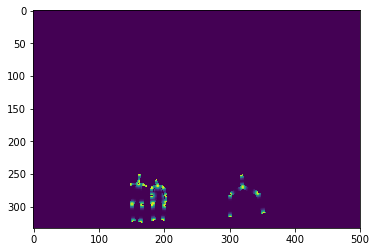

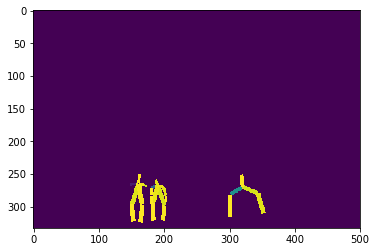

In [293]:
plt.figure()
plt.imshow(np.max(input_pose,axis=0))
plt.figure()
plt.imshow(np.max(input_paf,axis=0))
plt.show()

In [294]:
stft_p = input_pose
c, h, w = stft_p.shape
peak_counter = 0
all_peaks = []
for part in range(c):
    x_list = []
    y_list = []
    map_ori = stft_p[part,:,:]
    map_ori = map_ori/map_ori.max()
    thr1 = 0
#     map = map_ori
    map = gaussian_filter(map_ori, sigma=3)
#     plt.figure()
#     plt.imshow(map)
#     plt.show()
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > 2*thr1))
    peaks = zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]
    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)
    print(len(peaks))

print(peak_counter)
print(all_peaks[0][0])

3
3
3
4
3
3
3
0
3
3
2
3
3
0
36
(162, 252, 0.86070797642505781, 0)


/users/gpu/ayushya/miniconda2/envs/ayushya/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
/users/gpu/ayushya/miniconda2/envs/ayushya/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater_equal
/users/gpu/ayushya/miniconda2/envs/ayushya/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


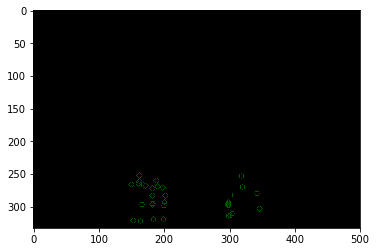

In [295]:
testim = np.zeros((input_pose.shape[1],input_pose.shape[2],3))
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
for peak in all_peaks:
    for human in peak:
        x_p = human[0]
        y_p = human[1]
        cv2.circle(testim, (int(x_p),int(y_p)), 4, colors[i])
plt.figure()
plt.imshow(testim)
plt.show()

In [296]:
limbSeq =  [[0,1],[1,2],[2,3],[3,4],[1,5],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13]]

connection_all = []
special_k = []
mid_num = 10
for k in range(len(limbSeq)):
    # print("k")
    score_mid = input_paf[[2*k,2*k+1],:,:]
    candA = all_peaks[limbSeq[k][0]]
    candB = all_peaks[limbSeq[k][1]]

    nA = len(candA)
    nB = len(candB)
    print(k,nA,nB)
    indexA, indexB = limbSeq[k]
    if(nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            # print(nB)
            for j in range(nB):
                # print("j")
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                if norm == 0:
                    continue
                vec = np.divide(vec, norm)

                startend = zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                           np.linspace(candA[i][1], candB[j][1], num=mid_num))

                vec_x = np.array([score_mid[0,int(round(startend[I][1])), int(round(startend[I][0]))] \
                          for I in range(len(startend))])
                vec_y = np.array([score_mid[1,int(round(startend[I][1])), int(round(startend[I][0]))] \
                          for I in range(len(startend))])

                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*h/norm-1, 0)

                criterion1 = fun1(score_midpts) > 0.6 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
#                 criterion2 = 1
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])
#                     print([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])
        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0,5))
        for c in range(len(connection_candidate)):
            # print("c")
            i,j,s = connection_candidate[c][0:3]
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if(len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

for i in range(len(connection_all)):
    if(connection_all[i] != []):
        print(i,connection_all[i].shape)

(0, 3, 3)
(1, 3, 3)
(2, 3, 4)
(3, 4, 3)
(4, 3, 3)
(5, 3, 3)
(6, 3, 0)
(7, 3, 3)
(8, 3, 3)
(9, 3, 2)
(10, 3, 3)
(11, 3, 3)
(12, 3, 0)
(0, (3, 5))
(1, (3, 5))
(2, (2, 5))
(3, (1, 5))
(4, (2, 5))
(5, (2, 5))
(7, (3, 5))
(8, (2, 5))
(9, (0, 5))
(10, (2, 5))
(11, (2, 5))


/users/gpu/ayushya/miniconda2/envs/ayushya/lib/python2.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


In [297]:
subset = -1 * np.ones((0, 16))
candidate = np.array([item for sublist in all_peaks for item in sublist])

for k in range(len(limbSeq)):
    if k not in special_k:
        partAs = connection_all[k][:,0]
        partBs = connection_all[k][:,1]
        indexA, indexB = np.array(limbSeq[k])
        for i in range(len(connection_all[k])): #= 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)): #1:size(subset,1):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1

            if found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2: # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                #print "found = 2"
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

        # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(16)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])
deleteIdx = []
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)
print(subset[:,:-2])


[[  0.   3.   6.  -1.  -1.  18.  21.  -1.  22.  -1.  -1.  30.  35.  -1.]
 [  1.   5.   8.  12.  -1.  -1.  -1.  -1.  24.  26.  -1.  -1.  -1.  -1.]
 [  2.   4.   7.  10.  14.  16.  20.  -1.  23.  25.  -1.  31.  34.  -1.]]


In [298]:
outim = np.ones((input_pose.shape[1],input_pose.shape[2],3))*100
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
for n in range(len(subset)):
    for i in range(14):
        index = subset[n][i]
        if(index<0):
            continue
        x_p = candidate[index.astype(int),0]
        y_p = candidate[index.astype(int),1]
#         print(x_p,y_p)
        cv2.circle(outim, (int(x_p),int(y_p)), 5, colors[i],thickness=-1)
    for i,limb in enumerate(limbSeq):
        index1 = subset[n][limb[0]]
        index2 = subset[n][limb[1]]
        if(index1<0 or index2<0):
            continue
        x_1 = candidate[index1.astype(int),1]
        y_1 = candidate[index1.astype(int),0]
        x_2 = candidate[index2.astype(int),1]
        y_2 = candidate[index2.astype(int),0]
        length = ((x_1 - x_2) ** 2 + (y_1 - y_2) ** 2) ** 0.5
        angle = math.degrees(math.atan2(x_1 - x_2, y_1 - y_2))
        polygon = cv2.ellipse2Poly((int((y_1+y_2)/2),int((x_1+x_2)/2)), (int(length/2), 4), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(outim, polygon, colors[i])

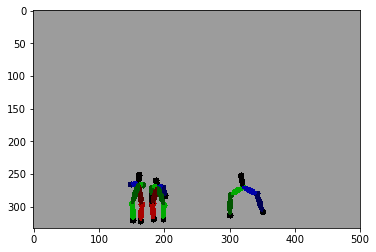

In [299]:
plt.figure()
plt.imshow(outim)
plt.show()